
# Downsides of decorrelation

The goal of decorrelation is to elliminate the correlation between two channels.
In principle, the hope was that this could be used to get a dataset which is nicely separable.

Experiments show that this does not work:
- Using PCA, we loose all information about the original channels, as the coordinate system completely changes, hence PCA doesn't work.
- The alternative, ZCA whitening works better. But the issue here is seems to be that the zero cluster and the single positives have much more weight than multiple positives and hence the transformation only seems to decorrelate single positives.

Experiments without decorrelation only work with perfect fine-tuning which must be done by hand, but an algorithm should be able to do this automatically.

Note that the whole approach heavily depends on the quality of the clusters and the tuning of the threshholds. The discussion in this document focuses rather on the aspects of decorrelation under the assumption, that the threshholds and clusters work with reasonable precision.

### Protocol of some experiments

The Idea of the experiments in this document, is:
1. First decorrelate the data, such that the data is changed as little as possible.
2. Then determine a threshhold for each dimension
3. Cluster the data
4. Classify the clusters

For now we assume clustering works well and efficiently, the main task is to determine the theshholds.

##### General observations.
All the experiments have the drawback that the transformation (decorelation / whitening)
in some way or another distorts the multipositive clusters, because they are underrepresented
and hence the covariance matrix over all the points cannot capture all of those clusters.

For this, we tried the following:

**Threshhold based on the negative control cluster variance, with variance normalization:**
For the choice of aggressivness used was 15, which is pretty robust, so 12-18  work about the same.
- This works reasonably well on most of the datasets and is pretty robust, in the sence of setting one threshhold for all the axis suffices.
- The downside is that on channel 6, this works pretty bad. There the zero cluster hardly has any variance and hence we have trouble estimating.

**Threshhold based on the whole clusters min-max, with variance normalization:**
- This approach work well on channel 6, because there the data is very nicely separable
- Fails for channel

**Threshhold based on the whole clusters variance, with variance normalization:**
The choice of aggressiveness of approximately 1.8 seemed to work best
- With this approach we have similar findings as threshholds based on the negative control

In [1]:

import numpy as np
import pandas as pd
import data_lib
import plot_lib
import transform_lib
import decision_lib
from sklearn import cluster

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13               

### Get samples for negative control

In [3]:
# negative control
#df_negative_control = data_lib.load_dataset([],["po-di-se-1-D1", "po-di-se-1-D4", "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-D8"])
df_negative_control = data_lib.load_dataset([],["wa-sa-D3", "wa-sa-D5"])
df_positive_control = data_lib.load_dataset([],["wa-sa-D3", "wa-sa-D5"])
np_negative_control = df_negative_control.to_numpy()
df_y_negative_control = pd.DataFrame(np.zeros(df_negative_control.shape[0]))

In [10]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", "wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  "wa-sa-B2",
                                     #"wa-sa-A5", "wa-sa-A3",
                                     #"wa-sa-C2",
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", "wa-sa-A4",
                                     #"wa-sa-A1", "wa-sa-D2",
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ])
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                #"wa-sa-D5"
                                                ])
df_positive_control = data_lib.load_dataset([],[
                                                "wa-sa-C3",
                                                #"wa-sa-C5"
                                                ])
np_negative_control = df_negative_control.to_numpy()
np_positive_control = df_positive_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]
ZCA_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.ZCA)
NONE_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.NONE)

In [37]:
# fix clustering algorithm
cluster_engine = cluster.DBSCAN(eps = 0.05, min_samples = 1, n_jobs=8)

# initialize desion maker based on negative control cluster and defined some settings
neg_cluster_based_classifier_zca = decision_lib.ThresholdClassifier(
                                            negative_control=np_negative_control,
                                            positive_control=np_positive_control,
                                            cluster_algorithm=cluster_engine,
                                            criterion="mixed",
                                            transform_base="pos",
                                            aggressiveness=1,
                                            whitening_transformer=ZCA_whitener,
                                            prediction_axis=['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
                                            )

neg_cluster_based_classifier_none = decision_lib.ThresholdClassifier(
                                            negative_control=np_negative_control,
                                            positive_control=np_positive_control,
                                            cluster_algorithm=cluster_engine,
                                            criterion="mixed",
                                            transform_base="pos",
                                            aggressiveness=5,
                                            whitening_transformer=NONE_whitener,
                                            prediction_axis=['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
                                            )

# fit the whitening transformer and compute thresholds for negative control culster
neg_cluster_based_classifier_none.fit(np_wa)
neg_cluster_based_classifier_zca.fit(np_wa)

# predict does not scale well due to clustering inside
df_predictions_none = neg_cluster_based_classifier_none.predict(np_wa)
df_predictions_zca = neg_cluster_based_classifier_zca.predict(np_wa)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot SARS-N1_POS associated with cannel 2
Example for zca beeing somewhat more robust than no transformation.

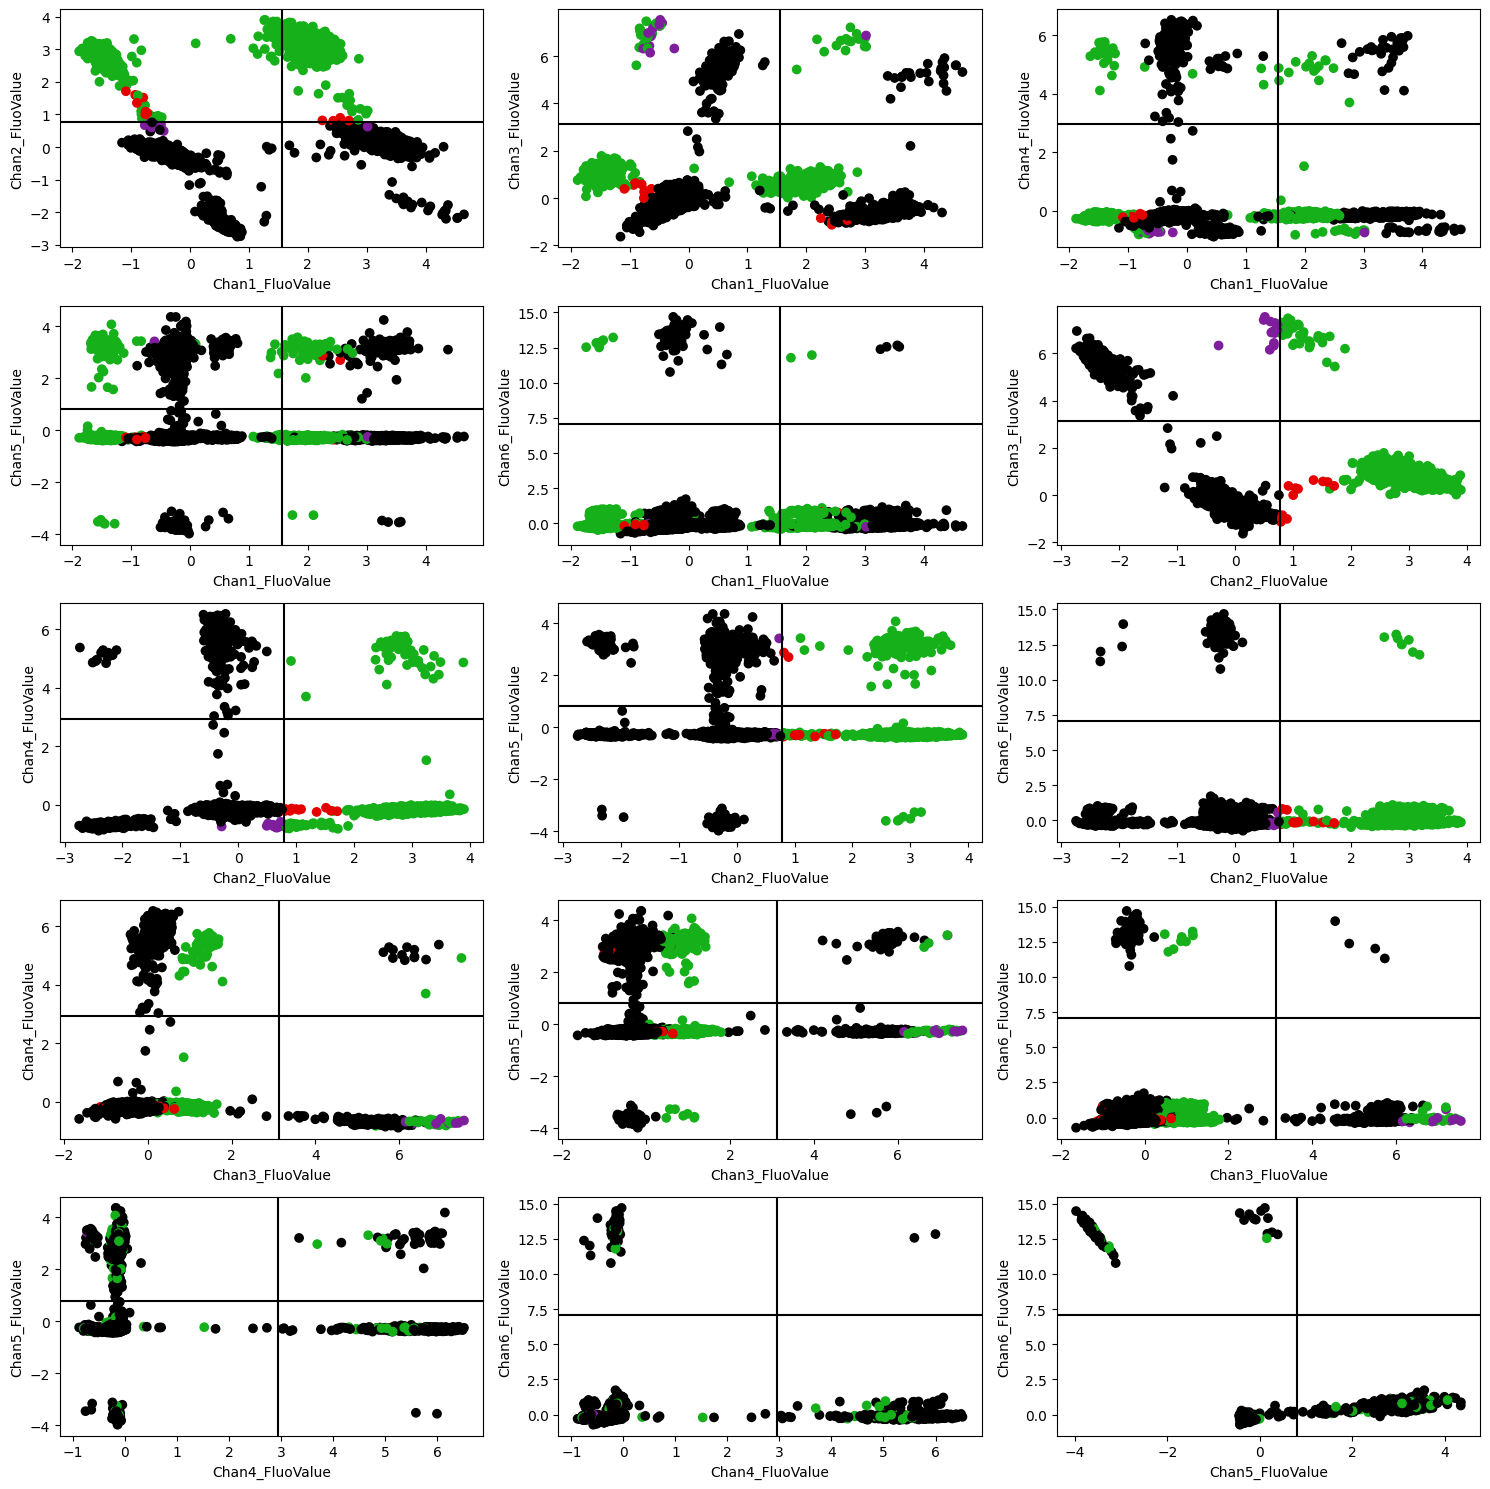

In [40]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier_zca.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                  df_predictions_zca["SARS-N1_POS"],
                                  df_wa.loc[:,"SARS-N1_POS"],
                                  axis_thresh=neg_cluster_based_classifier_zca.axis_threshholds
                                  )

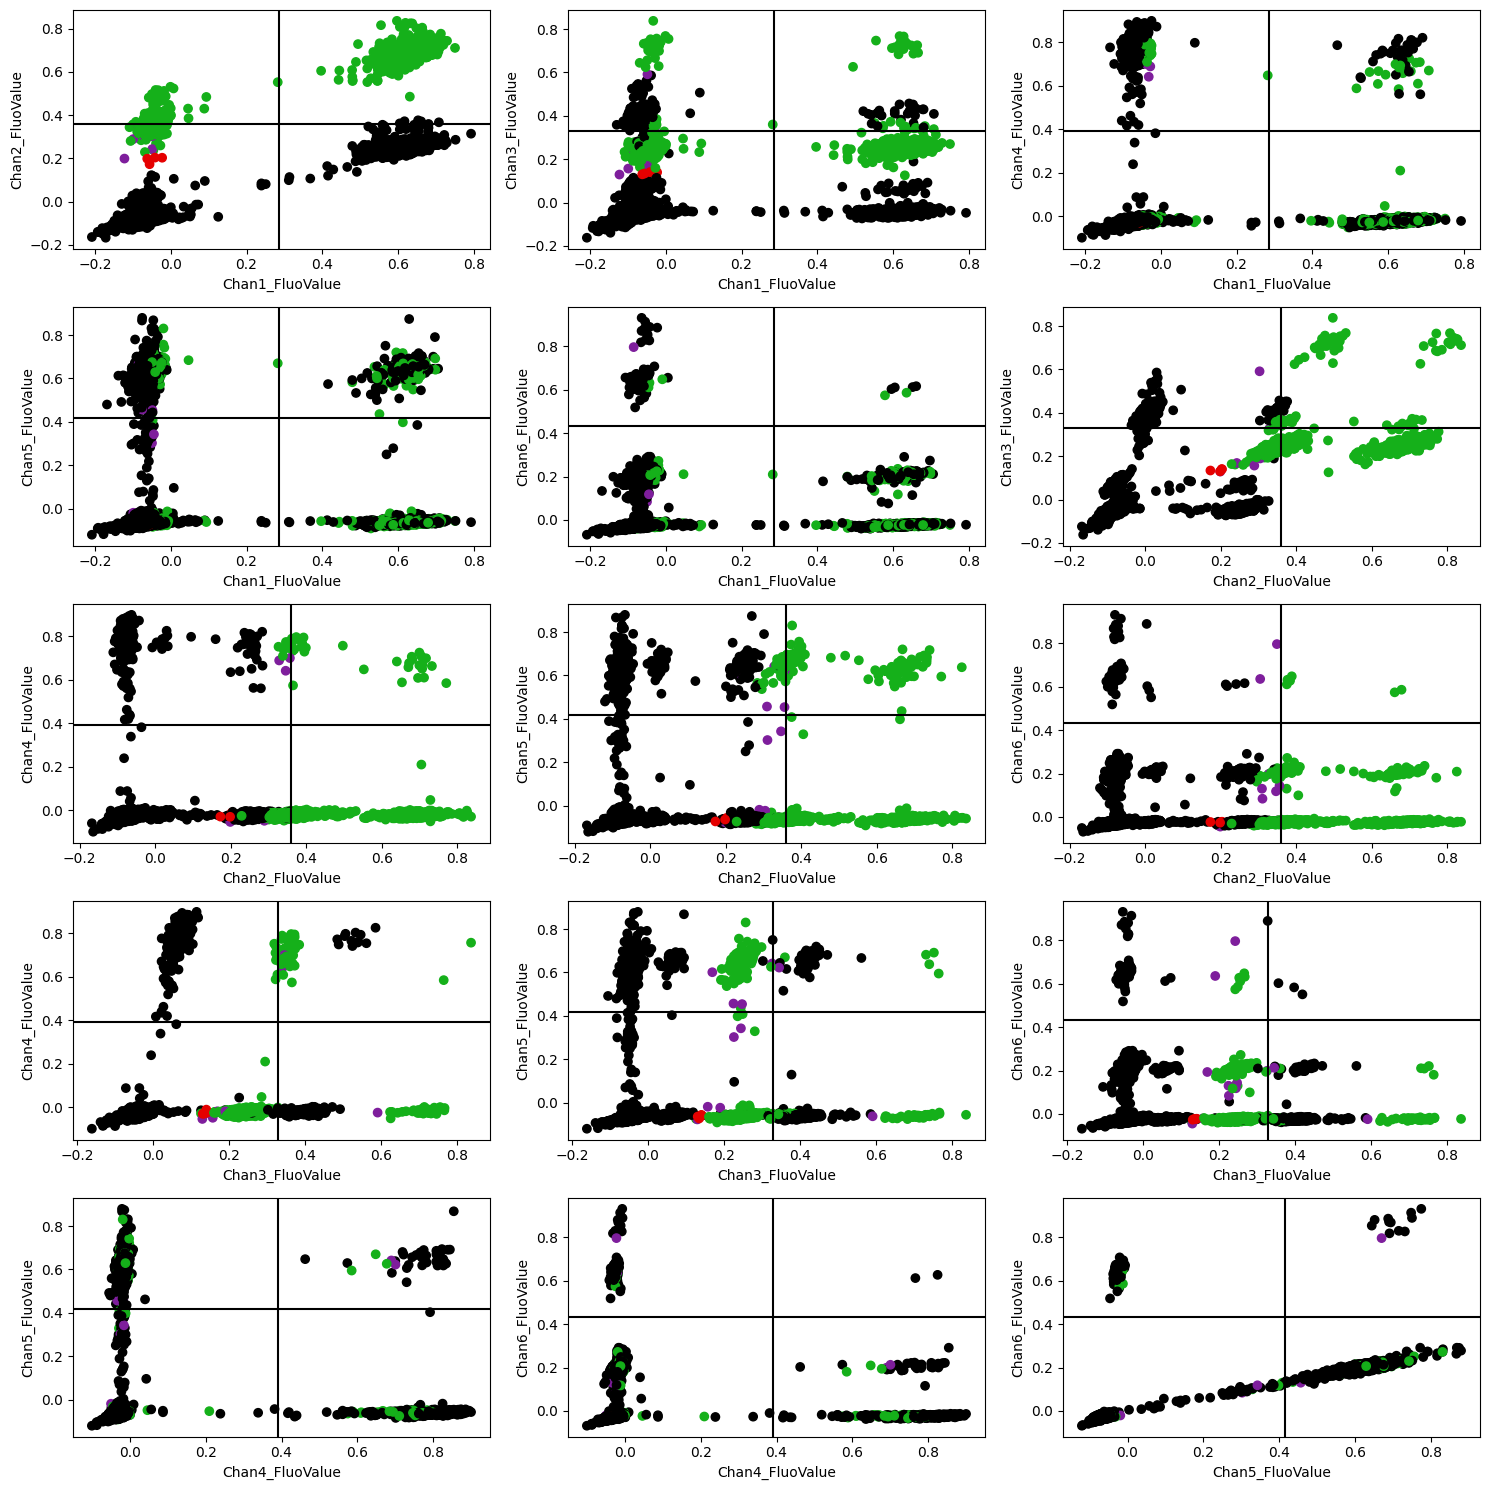

In [41]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier_none.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                  df_predictions_none["SARS-N1_POS"],
                                  df_wa.loc[:,"SARS-N1_POS"],
                                  axis_thresh=neg_cluster_based_classifier_none.axis_threshholds
                                  )

#### Plot IAV-M_POS associated with cannel 5
Example for the zca preforming worse than no transformation, see channel 5 vs channel 6. Due to the correlation, the double positives get shifted down in dimension 6 which is probably an effect of them beeing underrepresented. Meaning that the decorrelation is mainly determined by the zero cluster and the single positives and hence these points have almost no effect on the transformation, which results in them beeing moved by this much.

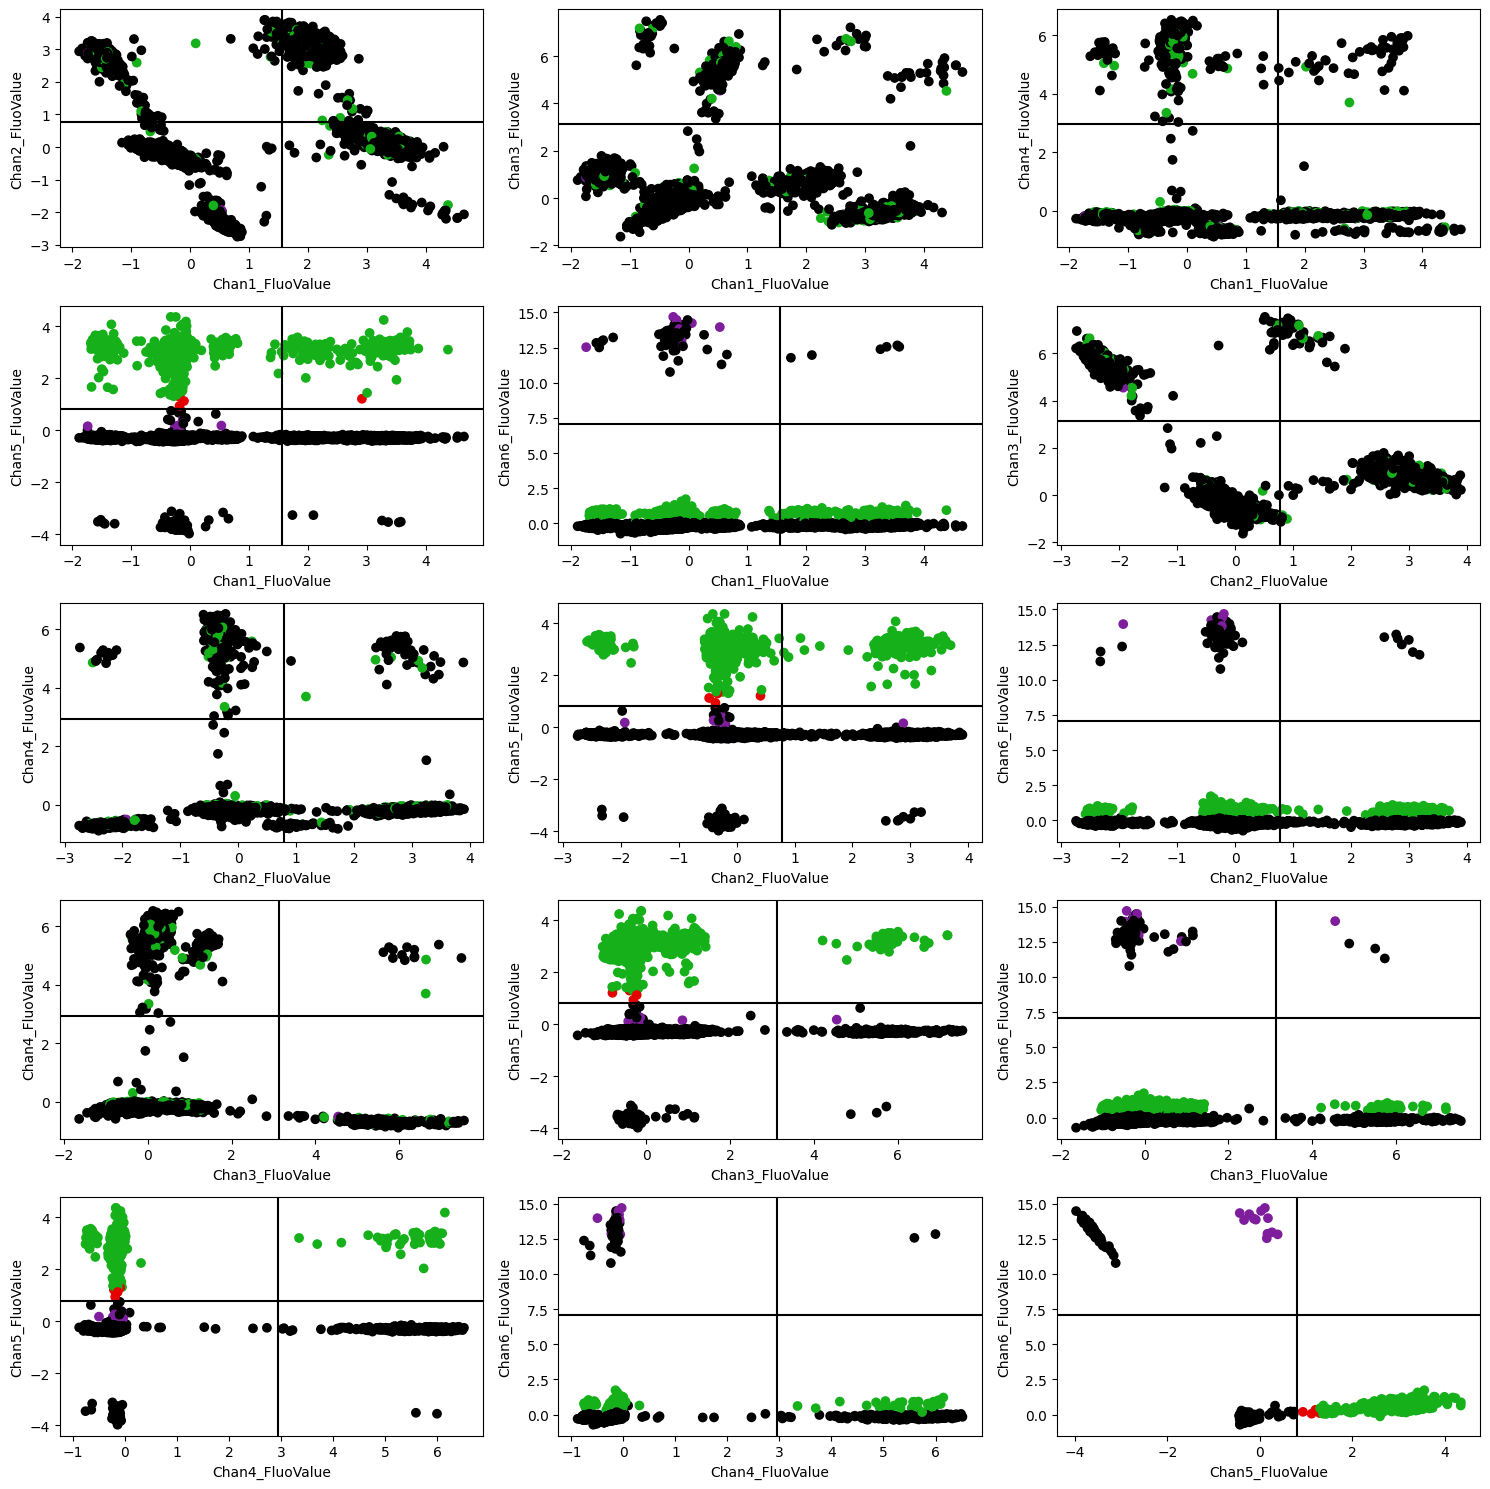

In [43]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier_zca.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions_zca["IAV-M_POS"],
                                         df_wa.loc[:,"IAV-M_POS"],
                                         axis_thresh=neg_cluster_based_classifier_zca.axis_threshholds,
                                         )

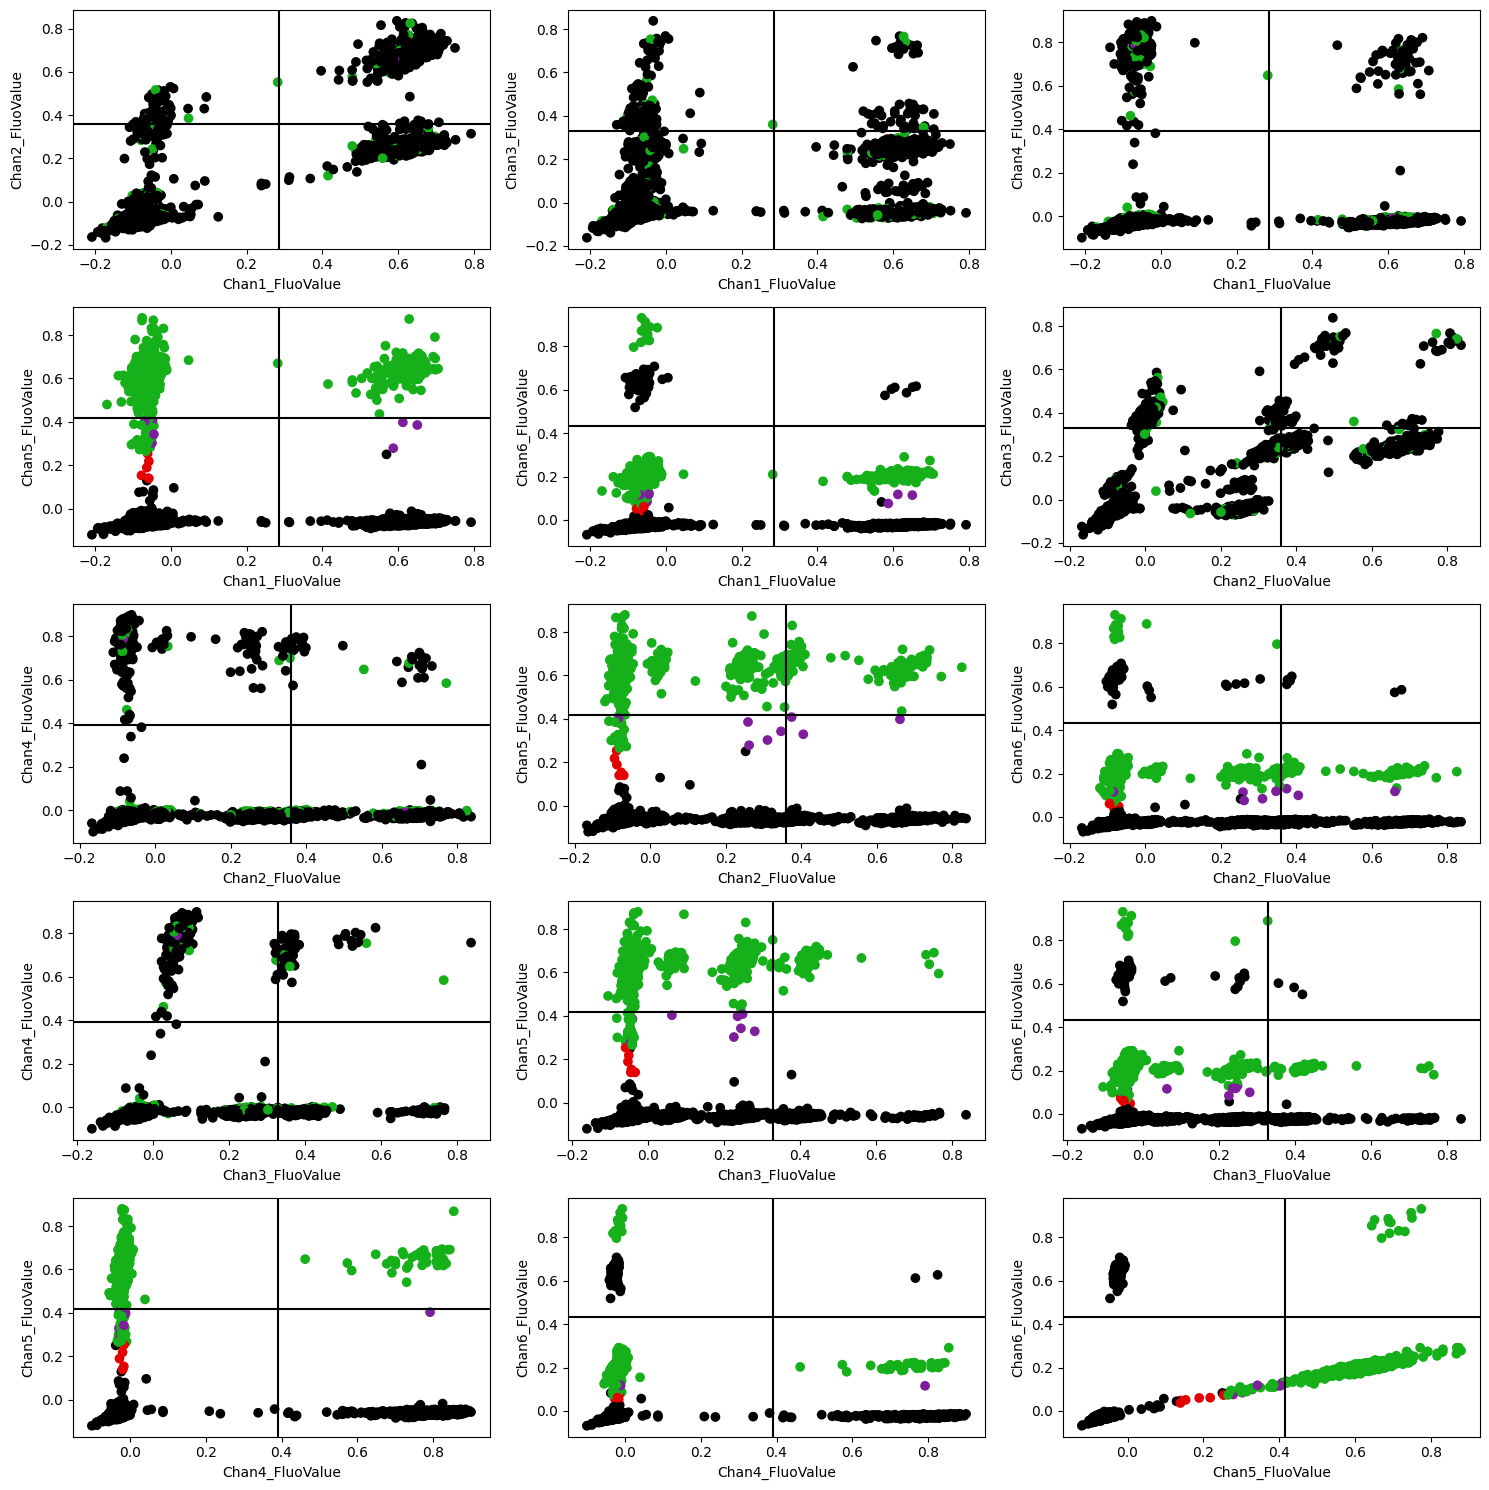

In [44]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier_none.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions_none["IAV-M_POS"],
                                         df_wa.loc[:,"IAV-M_POS"],
                                         axis_thresh=neg_cluster_based_classifier_none.axis_threshholds,
                                         )